In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,8)
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import *
from astrometry.util.util import Tan
from astrometry.util.plotutils import *
from collections import Counter
from astrometry.util.starutil import *
from scipy.ndimage.filters import *
from scipy.ndimage.measurements import label, find_objects
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes

In [90]:
g_det = fitsio.read('16/detmap-g.fits')
g_detiv = fitsio.read('16/detiv-g.fits')
r_det = fitsio.read('16/detmap-r.fits')
r_detiv = fitsio.read('16/detiv-r.fits')

img = plt.imread('16/legacysurvey-custom-036450m04600-image.jpg')
img = np.flipud(img)
H,W,three = img.shape

ra,dec = 36.45, -4.6
pixscale = 0.262 / 3600.
wcs = Tan(ra, dec, W/2.+0.5, H/2.+0.5,
        -pixscale, 0., 0., pixscale,
        float(W), float(H))

In [91]:
g_sn = g_det * np.sqrt(g_detiv)
r_sn = r_det * np.sqrt(r_detiv)

In [92]:
goodpix = np.logical_and(g_detiv > 0.5 * np.median(g_detiv),
                         r_detiv > 0.5 * np.median(r_detiv))

In [93]:
def sedsn(detmaps, detivs, sed):
    H,W = detmaps[0].shape
    sedmap = np.zeros((H,W), np.float32)
    sediv  = np.zeros((H,W), np.float32)
    for iband in range(len(detmaps)):
        # We convert the detmap to canonical band via
        #   detmap * w
        # And the corresponding change to sig1 is
        #   sig1 * w
        # So the invvar-weighted sum is
        #    (detmap * w) / (sig1**2 * w**2)
        #  = detmap / (sig1**2 * w)
        sedmap += detmaps[iband] * detivs[iband] / sed[iband]
        sediv  += detivs [iband] / sed[iband]**2
    sedmap /= np.maximum(1e-16, sediv)
    sedsn   = sedmap * np.sqrt(sediv)
    return sedsn

In [122]:
detmaps = [g_det, r_det]
detivs = [g_detiv, r_detiv]
flat_sn = sedsn(detmaps, detivs, [1., 1.])
red_sed = [2.5, 1.]
red_sn  = sedsn(detmaps, detivs, red_sed)
blue_sn = sedsn(detmaps, detivs, [1., 2.5])

In [95]:
def detect_sources(snmap, threshold, good=None):
    hot = (snmap > threshold)
    hot = binary_dilation(hot, iterations=2)
    hot = binary_fill_holes(hot)
    blobs,nblobs = label(hot)
    print(nblobs, 'blobs')
    print('blobs min', blobs.min(), 'max', blobs.max())
    slices = find_objects(blobs)
    px,py = [],[]
    for i,slc in enumerate(slices):
        blob_loc = blobs[slc]
        sn_loc = snmap[slc]
        imax = np.argmax((blob_loc == (i+1)) * sn_loc)
        y,x = np.unravel_index(imax, blob_loc.shape)
        y0,x0 = slc[0].start, slc[1].start
        px.append(x0+x)
        py.append(y0+y)
    px,py = np.array(px),np.array(py)
    if good is not None:
        I = np.flatnonzero(good[py,px])
        px = px[I]
        py = py[I]
    return px,py

In [96]:
gx,gy = detect_sources(g_sn, 5., good=goodpix)
rx,ry = detect_sources(r_sn, 5., good=goodpix)

9647 blobs
blobs min 0 max 9647
11814 blobs
blobs min 0 max 11814


In [97]:
fx,fy = detect_sources(flat_sn, 5., good=goodpix)
redx,redy = detect_sources(red_sn, 5., good=goodpix)

12334 blobs
blobs min 0 max 12334
12348 blobs
blobs min 0 max 12348


In [98]:
chix,chiy = detect_sources(np.hypot(g_sn, r_sn), 5., good=goodpix)

13342 blobs
blobs min 0 max 13342


In [99]:
c4x,c4y = detect_sources(np.hypot(g_sn, r_sn), 4., good=goodpix)

18380 blobs
blobs min 0 max 18380


In [116]:
c3x,c3y = detect_sources(np.hypot(g_sn, r_sn), 3., good=goodpix)

27583 blobs
blobs min 0 max 27583


In [111]:
allx = np.hstack((gx,rx,fx,chix))
ally = np.hstack((gy,ry,fy,chiy))

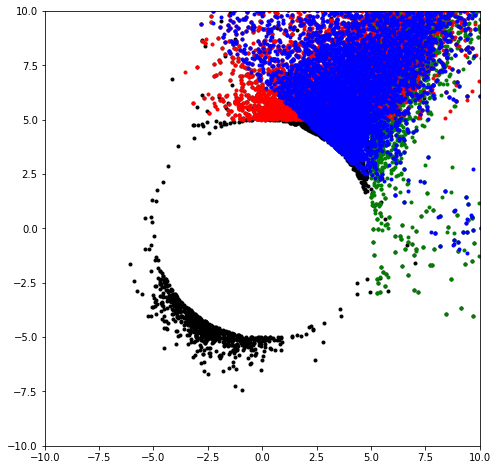

In [112]:
plt.plot(g_sn[chiy,chix], r_sn[chiy,chix], 'k.')
plt.plot(g_sn[gy,gx], r_sn[gy,gx], 'g.')
plt.plot(g_sn[ry,rx], r_sn[ry,rx], 'r.')
plt.plot(g_sn[fy,fx], r_sn[fy,fx], 'b.')
plt.axis('square')
plt.axis([-10,10,-10,10]);


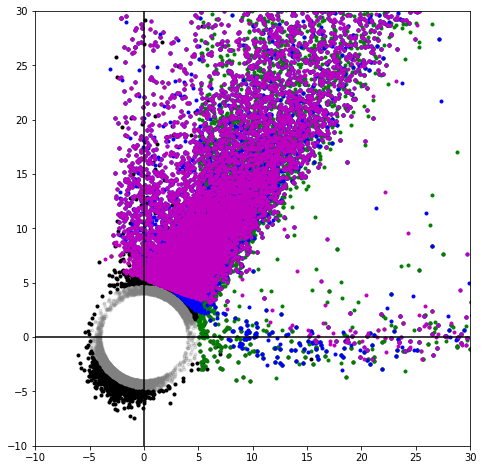

In [102]:
plt.plot(g_sn[c4y,c4x], r_sn[c4y,c4x], '.', color='0.5', alpha=0.2)
plt.plot(g_sn[chiy,chix], r_sn[chiy,chix], 'k.')
plt.plot(g_sn[gy,gx], r_sn[gy,gx], 'g.')
#plt.plot(g_sn[ry,rx], r_sn[ry,rx], 'r.')
plt.plot(g_sn[fy,fx], r_sn[fy,fx], 'b.')
plt.plot(g_sn[redy,redx], r_sn[redy,redx], 'm.')
plt.axis('square')
plt.axis([-10,30,-10,30]);
plt.axhline(0, color='k');
plt.axvline(0, color='k');

In [131]:
dm=[np.array([[1,0]]), np.array([[0,1]])]
div=[np.ones(2), np.ones(2)]
sn = sedsn(dm, div, red_sed)
print(sn)
sn[0,0] / sn[0,1]
sng = sn[0,0]
snr = sn[0,1]

[[0.37139067 0.9284767 ]]


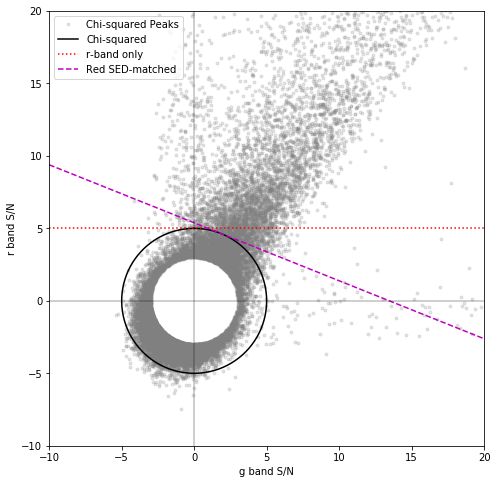

In [142]:
from matplotlib.patches import Circle
plt.plot(g_sn[c3y,c3x], r_sn[c3y,c3x], '.', color='0.5', alpha=0.2, label='Chi-squared Peaks')
# cheat!
#plt.gca().add_artist(Circle((0, 0), 3, color='0.5'))
# chi2
a = np.linspace(0, 2.*np.pi, 100)
plt.plot(5.*np.sin(a), 5.*np.cos(a), 'k-', label='Chi-squared')
# r
plt.axhline(5., color='r', linestyle=':', label='r-band only')
# red
m=-sng/snr
b=5./snr
xx = np.array([-10,20])
plt.plot(xx, b+m*xx, 'm-', mew=2, linestyle='--', label='Red SED-matched')
plt.legend(loc='upper left')
plt.axis('square')
plt.axis([-10,20,-10,20])
plt.xlabel('g band S/N')
plt.ylabel('r band S/N')
plt.axhline(0, color='k', alpha=0.25)
plt.axvline(0, color='k', alpha=0.25);

In [103]:
I = np.flatnonzero((g_sn[chiy,chix]<0) * (r_sn[chiy,chix]<0))
nx=chix[I]
ny=chiy[I]

In [104]:
def show_sources(T, img):
    sz = 10
    imgrows = []
    R,C = 10,10
    k = 0
    for i in range(R):
        imgrow = []
        for j in range(C):
            if k >= len(T):
                sub = np.zeros((sz*2+1,sz*2+1,3), np.uint8)
            else:
                f = T[k]
                sub = img[f.y-sz : f.y+sz+1, f.x-sz : f.x+sz+1, :]
            imgrow.append(sub)
            k += 1
        imgrow = np.hstack(imgrow)
        #print('imgrow', imgrow.shape)
        imgrows.append(imgrow)
    imgrows = np.vstack(reversed(imgrows))
    plt.imshow(imgrows, interpolation='nearest', origin='lower')
    plt.xticks([]); plt.yticks([]);

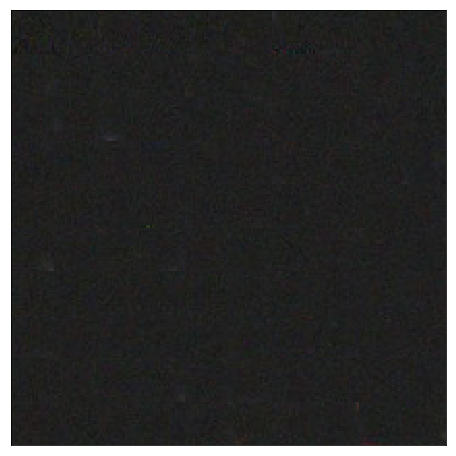

In [105]:
T = fits_table()
T.x = nx
T.y = ny
show_sources(T, img)

(-0.5, 3999.5, 4399.5, -0.5)

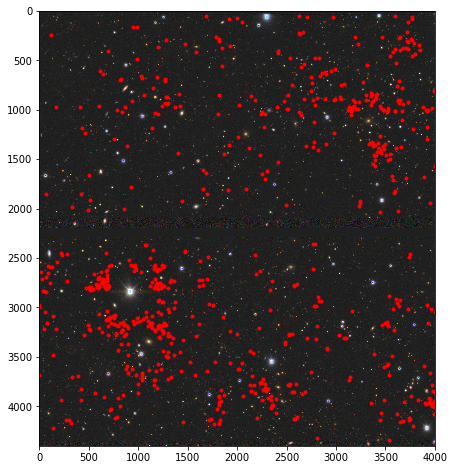

In [106]:
plt.imshow(img)
ax = plt.axis()
plt.plot(nx, ny, 'r.')
plt.axis(ax)

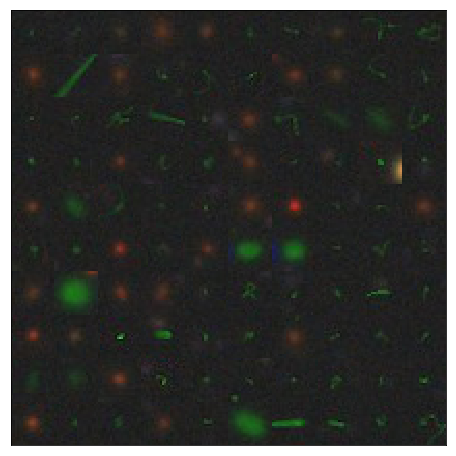

In [107]:
T = fits_table()
T.x = rx
T.y = ry
T.g_sn = g_sn[T.y, T.x]
T.r_sn = r_sn[T.y, T.x]
T.cut((T.r_sn > 20) * (T.g_sn < 5))
sz = 10
T.cut((T.x > sz) * (T.y > sz) * (T.x < (W-sz)) * (T.y < (H-sz)))
show_sources(T, img)

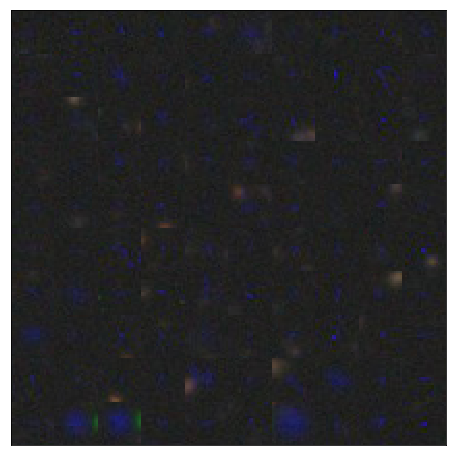

In [108]:
T = fits_table()
T.x = gx
T.y = gy
T.g_sn = g_sn[T.y, T.x]
T.r_sn = r_sn[T.y, T.x]
T.cut((T.g_sn > 20) * (T.r_sn < 5))
sz = 10
T.cut((T.x > sz) * (T.y > sz) * (T.x < (W-sz)) * (T.y < (H-sz)))
show_sources(T, img)

(-0.5, 3999.5, 4399.5, -0.5)

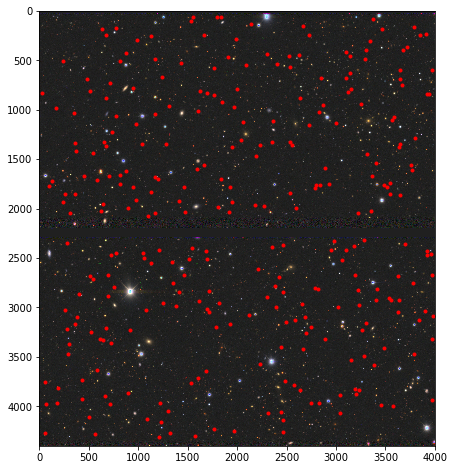

In [69]:
plt.imshow(img)
ax = plt.axis()
plt.plot(T.x, T.y, 'r.')
plt.axis(ax)

In [143]:
g_det1 = fitsio.read('1/detmap-g.fits')
g_detiv1 = fitsio.read('1/detiv-g.fits')
r_det1 = fitsio.read('1/detmap-r.fits')
r_detiv1 = fitsio.read('1/detiv-r.fits')

In [144]:
g_sn1 = g_det1 * np.sqrt(g_detiv1)
r_sn1 = r_det1 * np.sqrt(r_detiv1)

In [145]:
goodpix1 = np.logical_and(g_detiv1 > 0.5 * np.median(g_detiv1),
                         r_detiv1 > 0.5 * np.median(r_detiv1))


In [146]:
detmaps1 = [g_det1, r_det1]
detivs1 = [g_detiv1, r_detiv1]
red_sn1  = sedsn(detmaps1, detivs1, red_sed)

In [147]:
c3x,c3y = detect_sources(np.hypot(g_sn1, r_sn1), 3., good=goodpix1)


26381 blobs
blobs min 0 max 26381


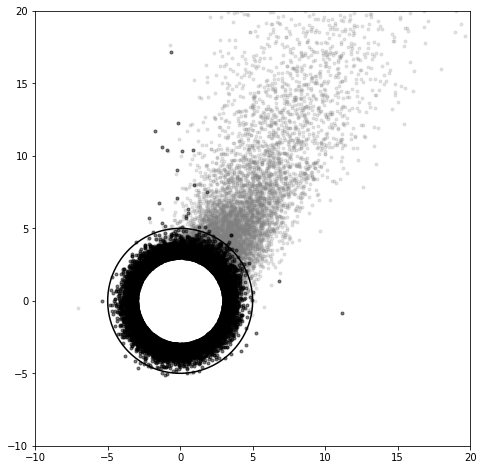

In [161]:
#plt.plot(g_sn[c3y,c3x], r_sn[c3y,c3x], '.', color='0.5', alpha=0.2, label='Chi-squared Peaks')
#plt.scatter(g_sn1[c3y,c3x], r_sn1[c3y,c3x], s=4, c=np.hypot(g_sn[c3y,c3x],r_sn[c3y,c3x]), vmin=0, vmax=20)
real = np.flatnonzero(np.hypot(g_sn[c3y,c3x], r_sn[c3y,c3x]) > 5.)
fake = np.flatnonzero(np.hypot(g_sn[c3y,c3x], r_sn[c3y,c3x]) <= 5.)
plt.plot(g_sn1[c3y,c3x][real], r_sn1[c3y,c3x][real], '.', color='0.5', alpha=0.2, label='Real Peaks')
plt.plot(g_sn1[c3y,c3x][fake], r_sn1[c3y,c3x][fake], '.', color='k', alpha=0.5, label='Fake Peaks')

a = np.linspace(0, 2.*np.pi, 100)
plt.plot(5.*np.sin(a), 5.*np.cos(a), 'k-', label='Chi-squared detection')

plt.axis('square')
plt.axis([-10,20,-10,20]);